# Red Light Intersection Crash Analysis

Linear regression analysis of factors affecting red light crashes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
# import dask
# import dask.dataframe as dd
import gc

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('int_chars',), ('intersection_counts',), ('cam_locations',), ('cam_startend',), ('daily_violations',), ('intersction_locations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('intersection_chars',)]
int_chars
	-traffic_volume_count_location_address
	-total_passing_vehicle_volume

intersection_counts
	-traffic_volume_count_location_address
	-total_passing_vehicle_volume

cam_locations
	-camera_id
	-intersection
	-address
	-latitude
	-longitude
	-day

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

intersction_locations
	-intersection
	-latitude
	-longitude

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surfa

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

In [4]:
# LINK daily_violations to hourly_congestion through intersection_cams
crash_df = pd.read_sql_query('''
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection
                                        cr.region_id
                                FROM hourly_weather as wx
                                JOIN hourly_congestion as c
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                JOIN signal_crashes as cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                    ''', conn)

DatabaseError: Execution failed on sql '
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection
                                        cr.region_id
                                FROM hourly_weather as wx
                                JOIN hourly_congestion as c
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                JOIN signal_crashes as cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                    ': near ".": syntax error

In [ ]:
# TRY 2
# LINK daily_violations to hourly_congestion through intersection_cams
crash_df = pd.read_sql_query('''WITH cr AS(
                                        SELECT  posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour,
                                                region_id
                                         FROM signal_crashes
                                        )
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.day,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection
                                FROM hourly_congestion as c
                                LEFT JOIN hourly_weather as wx
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                LEFT JOIN cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                      AND c.region_id = cr.region_id
                                
                                WHERE wx.year >2015
                                    ''', conn)

In [ ]:
# TRY 3
# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH cr AS(
                                        SELECT  posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour,
                                                region_id
                                         FROM signal_crashes
                                        ),
                                    ic AS(
                                        SELECT *
                                        FROM intersection_chars
                                        )
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.day,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection,
                                        ic.daily_traffic
                                FROM hourly_congestion as c
                                LEFT JOIN hourly_weather as wx
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                LEFT JOIN cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                      AND c.region_id = cr.region_id
                                LEFT JOIN ic
                                    ON cr.intersection = ic.intersection
                                
                                WHERE wx.year >2015
                                     
                                
                                    ''', conn)

# WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [ ]:
# MY BIG DF
# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

big_df = pd.read_sql_query('''WITH ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   wx AS(SELECT  snow_1h,
                                                 rain_1h,
                                                 temp,
                                                 year,
                                                 month,
                                                 day,
                                                 weekday
                                         FROM hourly_weather
                                         WHERE year > 2015
                                         ), 
                                         
                                   cr AS(SELECT posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day
                                         FROM signal_crashes
                                         WHERE year > 2015
                                        ),
                                        
                                    joined AS(SELECT cr.intersection,
                                                    cr.injuries_total,
                                                    wx.year,
                                                    wx.month,
                                                    wx.day,
                                                    wx.temp,
                                                    wx.snow_1h,
                                                    wx.rain_1h
                                            FROM wx
                                            LEFT JOIN cr
                                                ON cr.year = wx.year
                                                AND cr.month = wx.month
                                                AND cr.day = wx.day

                                            UNION ALL

                                            SELECT  cr.intersection,
                                                    cr.injuries_total,
                                                    wx.year,
                                                    wx.month,
                                                    wx.day,
                                                    wx.temp,
                                                    wx.snow_1h,
                                                    wx.rain_1h
                                            FROM cr
                                            LEFT JOIN wx
                                                ON cr.year = wx.year
                                                AND cr.month = wx.month
                                                AND cr.day = wx.day
                                            )
                                        
                                SELECT  joined.year,
                                        joined.month,
                                        joined.day,
                                        GROUP_CONCAT(joined.intersection) as intersections,
                                        SUM(joined.injuries_total) as injuries_total,
                                        COUNT(joined.intersection) as n_crash,
                                        joined.snow_1h + joined.rain_1h as precip
                                        
                                FROM joined      
                                
                                WHERE joined.year > 2015
                                GROUP BY joined.year, joined.month, joined.day
                                ORDER BY joined.year, joined.month, joined.day
                                    ''', conn)

# got all my crashes together
# GROUP_CONCAT ??

# TO DO FULL OUTER JOIN IN SQLITE3...
# SELECT d.type,
#          d.color,
#          c.type,
#          c.color
# FROM dogs d
# LEFT JOIN cats c USING(color)
# UNION ALL
# SELECT d.type,
#          d.color,
#          c.type,
#          c.color
# FROM cats c
# LEFT JOIN dogs d USING(color)
# WHERE d.color IS NULL;

In [ ]:
# Try 3
# MY BIG DF


############ GOT IT!!!!!!!!!!!!
# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   wx AS(SELECT  snow_1h,
                                                 rain_1h,
                                                 temp,
                                                 year,
                                                 month,
                                                 day,
                                                 hour
                                         FROM hourly_weather
                                         WHERE year > 2015
                                         ), 
                                         
                                   cr AS(SELECT crash_record_id,
                                               posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour
                                         FROM signal_crashes
                                         WHERE year > 2015
                                        )
                                        
                                        
                                SELECT  wx.year,
                                        wx.month,
                                        wx.day,
                                        wx.hour,
                                        (wx.snow_1h + wx.rain_1h) as precip,
                                        MAX(wx.temp),
                                        
                                        GROUP_CONCAT(cr.intersection) as intersection_list,
                                        COUNT(cr.crash_record_id) as n_crash,
                                        SUM(cr.injuries_total) as injuries_total,
                                        SUM(cr.injuries_fatal) as injuries_fatal,
                                        GROUP_CONCAT(cr.posted_speed_limit) as posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        SUM(injuries_incapacitating) as injuries_incapacitating,
                                        injuries_non_incapacitating,
                                        injuries_reported_not_evident,
                                        injuries_no_indication,
                                        injuries_unknown,
                                        work_zone_i,
                                        work_zone_type,
                                        workers_present_i,
                                        
                                        ic.protected_turn, 
                                        ic.total_lanes, 
                                        ic.medians, 
                                        ic.exit, 
                                        ic.split, 
                                        ic.way,
                                        ic.underpass, 
                                        ic.no_left, 
                                        ic.angled, 
                                        ic.triangle, 
                                        ic.one_way, 
                                        ic.turn_lanes,
                                        ic.rlc, 
                                        ic.daily_traffic
                                        
                                        
                                FROM wx   
                                LEFT JOIN cr
                                    ON cr.year=wx.year
                                        AND cr.month = wx.month
                                        AND cr.day = wx.day
                                        AND cr.hour = wx.hour
                                LEFT JOIN ic
                                    ON ic.intersection = cr.intersection
        
                                WHERE wx.year > 2015
                                GROUP BY wx.year, wx.month, wx.day, wx.hour
                                ORDER BY wx.year, wx.month, wx.day, wx.hour
                                    ''', conn)


# TO DO FULL OUTER JOIN IN SQLITE3...
# SELECT d.type,
#          d.color,
#          c.type,
#          c.color
# FROM dogs d
# LEFT JOIN cats c USING(color)
# UNION ALL
# SELECT d.type,
#          d.color,
#          c.type,
#          c.color
# FROM cats c
# LEFT JOIN dogs d USING(color)
# WHERE d.color IS NULL;

In [ ]:
# Try 3. DAILY
# MY BIG DF
# This time, I will shoot for every intersection for every hour

# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH v AS(SELECT SUM(violations) as violations,
                                                 year,
                                                 month,
                                                 day,
                                                 intersection,
                                                 weekday
                                            FROM daily_violations
                                            GROUP BY year, month, day, intersection
                                            ), 

                                    ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   wx AS(SELECT SUM(snow_1h) as snow_1h,
                                                 SUM(rain_1h) as rain_1h,
                                                 (SUM(snow_1h) + SUM(rain_1h)) as precip,
                                                 AVG(temp) as temp,
                                                 year,
                                                 month,
                                                 day
                                         FROM hourly_weather
                                        WHERE year > 2015

                                         GROUP BY year, month, day
                                         ), 
                                         
                                   cr AS(SELECT crash_record_id,
                                                posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour
                                         FROM signal_crashes
                                         WHERE year > 2015
                                        ),
                                        
                                joined AS(SELECT v.*, cr.*
                                                FROM  v
                                            
                                            LEFT JOIN cr 
                                                ON cr.year = v.year
                                                AND cr.month = v.month
                                                AND cr.day = v.day
                                                AND cr.intersection = v.intersection
                                            
                                            UNION ALL
                                            
                                            SELECT v.*, cr.*
                                                FROM cr

                                            LEFT JOIN v 
                                                ON cr.year = v.year
                                                AND cr.month = v.month
                                                AND cr.day = v.day
                                                AND cr.intersection = v.intersection
                                            )
                                
                                              
                                SELECT joined.*,
                                       wx.*,
                                       ic.*,
                                       COUNT(joined.crash_record_id) as n_crash

                                FROM joined
                                        
                                LEFT JOIN wx
                                    ON wx.year = joined.year
                                    AND wx.month = joined.month
                                    AND wx.day = joined.day
                                LEFT JOIN ic
                                    ON ic.intersection = joined.intersection
                                
                                WHERE joined.year > 2015
                                GROUP BY joined.year, joined.month, joined.day, joined.hour, joined.intersection
                                ORDER BY joined.year, joined.month, joined.day, joined.hour, joined.intersection
                                    ''', conn)






In [ ]:
# Try 4. MONTHLY
# MY BIG DF
# This time, I will shoot for every intersection for every hour

# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH v AS(SELECT SUM(violations) as violations,
                                                 year,
                                                 month,
                                                 day,
                                                 intersection,
                                                 weekday
                                            FROM daily_violations
                                            GROUP BY year, month, intersection
                                            ), 

                                    ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   wx AS(SELECT SUM(snow_1h) as snow_1h,
                                                 SUM(rain_1h) as rain_1h,
                                                 (SUM(snow_1h) + SUM(rain_1h)) as precip,
                                                 AVG(temp) as temp,
                                                 year,
                                                 month
                                         FROM hourly_weather
                                        WHERE year > 2015

                                         GROUP BY year, month
                                         ), 
                                         
                                   cr AS(SELECT crash_record_id,
                                                posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour
                                         FROM signal_crashes
                                         WHERE year > 2015
                                        ),
                                        
                                joined AS(SELECT v.*, cr.*
                                                FROM  v
                                            
                                            LEFT JOIN cr 
                                                ON cr.year = v.year
                                                AND cr.month = v.month
                                                AND cr.intersection = v.intersection
                                            
                                            UNION ALL
                                            
                                            SELECT v.*, cr.*
                                                FROM cr

                                            LEFT JOIN v 
                                                ON cr.year = v.year
                                                AND cr.month = v.month
                                                AND cr.intersection = v.intersection
                                            )
                                
                                              
                                SELECT joined.*,
                                       wx.*,
                                       ic.*,
                                       COUNT(joined.crash_record_id) as n_crash

                                FROM joined
                                        
                                LEFT JOIN wx
                                    ON wx.year = joined.year
                                    AND wx.month = joined.month
                                LEFT JOIN ic
                                    ON ic.intersection = joined.intersection
                                
                                WHERE joined.year > 2015
                                GROUP BY joined.year, joined.month, joined.day, joined.intersection
                                ORDER BY joined.year, joined.month, joined.day, joined.intersection
                                    ''', conn)




In [ ]:
# back to the drawing board.  
# We will get lifetime data on every intersection and figure out what causes accidents.  What makes them safe.

# Try 4. LIFETIME OF THE CAM.  This one requires cam_startend and we need to look at crashes per day as the output.  Probalby need scaling

# MY BIG DF
# This time, I will shoot for every intersection for every hour

# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH v AS(SELECT SUM(violations) as violations,
                                                 intersection,
                                                 (COUNT(violations)/COUNT(DISTINCT camera_id)) as days_active,
                                                 COUNT(DISTINCT dv.camera_id) as n_cams
                                            FROM daily_violations as dv
                                            WHERE year > 2015
                                            GROUP BY intersection
                                            ), 
                                            
                                    se AS(SELECT intersection,
                                                (CASE
                                                    WHEN s.end < s.start THEN s.start
                                                    ELSE s.end
                                                END) as end,
                                                (CASE
                                                    WHEN s.start < '2016-01-01 00:00:00' THEN '2016-01-01 00:00:00'
                                                    ELSE s.start
                                                END) as start
                                            
                                            FROM cam_startend as s
                                            LEFT JOIN cam_locations as c 
                                                ON c.camera_id = s.camera_id
                                            GROUP BY intersection
                                        ),

                                    ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   cr AS(SELECT SUM(injuries_total) as injuries_total,
                                                SUM(injuries_fatal) as injuries_fatal,
                                                SUM(injuries_incapacitating) as injuries_incapacitating,
                                                SUM(injuries_non_incapacitating) as injuries_non_incapacitating,
                                                SUM(injuries_unknown) as injuries_unknown,
                                                COUNT(crash_record_id) as n_crash,
                                                intersection
                                         FROM signal_crashes
                                         WHERE year > 2015
                                         GROUP BY intersection
                                        )
                                        
                                SELECT cr.*,
                                       v.*,
                                       ic.*,
                                       (ic.daily_traffic/ic.total_lanes) as traffic_density,
                                       (ic.exit + ic.split + ic.triangle + ic.angled + ic.one_way + ic.no_left + ic.way-4) as complexity,
                                       CAST((365 * cr.injuries_total / v.days_active) as REAL) as injuries_per_year,
                                       CAST((365 * cr.n_crash / v.days_active) as REAL) as crash_per_year,
                                       se.start,
                                       se.end,
                                       CAST((JulianDay(se.end) - JulianDay(se.start)) as Integer) as delta_days

                                FROM ic  
                                LEFT JOIN v
                                    ON v.intersection = ic.intersection
                                LEFT JOIN cr
                                    ON cr.intersection = ic.intersection
                                LEFT JOIN se
                                    ON se.intersection = ic.intersection
                                ORDER BY ic.intersection
                                    ''', conn)




In [471]:
# Try 5. All the same, but now I need to exclude before after start/end dates.  Need to bring back in days

# MY BIG DF
# This time, I will shoot for every intersection for every hour

# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH v AS(SELECT dv.intersection,
                                                SUM(dv.violations) as violations,
                                                (CASE
                                                    WHEN JulianDay(se.start) < JulianDay('2016-01-01 00:00:00') 
                                                        THEN CAST((JulianDay(se.end) - JulianDay('2016-01-01 00:00:00')) as Integer)
                                                    ELSE CAST((JulianDay(se.end) - JulianDay(se.start)) as Integer)
                                                END) as days_active,
                                                COUNT(DISTINCT dv.camera_id) as n_cams,
                                                start,
                                                end

                                            FROM daily_violations as dv
                                            LEFT JOIN cam_startend as se
                                                ON se.camera_id = dv.camera_id
                                            LEFT JOIN cam_locations as c
                                                ON c.camera_id = se.camera_id
                                            
                                            WHERE dv.violation_date >= se.start
                                                AND dv.violation_date <= se.end
                                                AND year > 2015
                                            GROUP BY dv.intersection
                                            ), 
                                 
                                    ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   cr AS(SELECT *   
                                         FROM signal_crashes
                                         WHERE year > 2015
                                        )
                                        
                                SELECT 
                                    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / v.days_active) as injuries_per_year,
                                    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ v.days_active) as crash_per_year,
                                    (ic.daily_traffic/ic.total_lanes) as traffic_density,
                                    (ic.exit + ic.split + ic.triangle + ic.angled + ic.one_way + ic.no_left + ic.way-4) as complexity,
                                    ic.*,
                                    v.*,
                                    COUNT(crash_record_id) as n_crash,
                                    SUM(injuries_total) as injuries_total,
                                    SUM(injuries_fatal) as injuries_fatal,
                                    SUM(injuries_incapacitating) as injuries_incapacitating,
                                    SUM(injuries_non_incapacitating) as injuries_non_incapacitating
                                    

                                FROM v  
                                LEFT JOIN ic
                                    ON v.intersection = ic.intersection
                                LEFT JOIN cr
                                    ON cr.intersection = ic.intersection
                                WHERE cr.crash_date >= v.start AND cr.crash_date <= v.end
                                GROUP BY ic.intersection
                                ORDER BY ic.intersection
                                    ''', conn)


# 
# 
# v.start,
# v.end,
# CAST((JulianDay(v.end) - JulianDay(v.start)) as Integer) as delta_days

In [472]:


sql_fetch_tables(c, conn)

[('int_chars',),
 ('intersection_counts',),
 ('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('intersction_locations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('signal_crashes',),
 ('intersection_chars',)]

In [473]:
pd.options.display.max_columns = 100
len(crash_df)
crash_df.days_active.unique()
crash_df.head()

,injuries_per_year,crash_per_year,traffic_density,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,intersection,daily_traffic,intersection,violations,days_active,n_cams,start,end,n_crash,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating
0,6.396495,9.994524,7183,1,2,6,2,0,0,4,0,0,1,0,0,2,41.692362,-87.642423,1,111TH AND HALSTED,43100,111TH AND HALSTED,21792,1826,2,2015-01-01 00:00:00,2020-12-31 00:00:00,50,32,0,3,17
1,0.000000,1.099398,7083,0,4,6,2,0,0,4,0,0,0,0,0,4,41.685089,-87.642094,1,115TH AND HALSTED,42500,115TH AND HALSTED,10290,664,2,2015-01-01 00:00:00,2017-10-26 00:00:00,2,0,0,0,0
2,4.397590,8.595290,6966,0,4,6,2,0,0,4,0,0,0,0,0,4,41.677774,-87.641930,1,119TH AND HALSTED,41800,119TH AND HALSTED,20257,1826,2,2015-01-01 00:00:00,2020-12-31 00:00:00,43,22,0,1,11
3,3.797919,9.994524,4610,3,2,10,2,0,1,4,0,2,0,0,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,46100,31ST ST AND MARTIN LUTHER KING DRIVE,25816,1826,2,2015-01-01 00:00:00,2020-12-31 00:00:00,50,19,0,1,11
4,3.797919,18.389923,8075,1,2,8,2,0,1,4,0,0,0,0,0,2,41.830281,-87.684775,1,35TH AND WESTERN,64600,35TH AND WESTERN,10891,1826,2,2015-01-02 00:00:00,2020-12-31 00:00:00,92,19,0,1,14


This is a massive dataframe when using hours. We have an intersection row for every


In [474]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


In [475]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [476]:
# now drop out the columns that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['violations'], inplace=True)

In [477]:
# approximate number of entries is 1.6M
print('Total days:', 365.25 * 5)

# approximate number of entries is 1.6M
print('Total month entries:', 12 * 5 * 159)

# additional entries may occur for double accidents
# fewer entries for inactive cameras
print('Est. Total day entries:', 365 * 159 * 5) # 5 years and 183 intersections for now


print()
crash_df.info()
len(crash_df.intersection.unique())

Total days: 1826.25
Total month entries: 9540
Est. Total day entries: 290175

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 31 columns):
injuries_per_year              158 non-null float64
crash_per_year                 158 non-null float64
traffic_density                158 non-null int64
complexity                     158 non-null int64
protected_turn                 158 non-null int64
total_lanes                    158 non-null int64
medians                        158 non-null int64
exit                           158 non-null int64
split                          158 non-null int64
way                            158 non-null int64
underpass                      158 non-null int64
no_left                        158 non-null int64
angled                         158 non-null int64
triangle                       158 non-null int64
one_way                        158 non-null int64
turn_lanes                     158 non-null int64
lat          

158

##### pd.options.display.max_columns = 100
#crash_df.head(100)
crash_df.isna().sum()


In [478]:
crash_df[crash_df.n_crash.isna()]  # missing two intersections. HUH!!!

# First one is at the Home Depot towards Lincolnwood.  That's a crazy intersection. 
# I will drop it for now, but would like to go back ans see what happened here.
crash_df.dropna(subset=['intersection'], inplace=True)

In [479]:
crash_df.isna().sum()

injuries_per_year              0
crash_per_year                 0
traffic_density                0
complexity                     0
protected_turn                 0
total_lanes                    0
medians                        0
exit                           0
split                          0
way                            0
underpass                      0
no_left                        0
angled                         0
triangle                       0
one_way                        0
turn_lanes                     0
lat                            0
long                           0
rlc                            0
intersection                   0
daily_traffic                  0
violations                     0
days_active                    0
n_cams                         0
start                          0
end                            0
n_crash                        0
injuries_total                 0
injuries_fatal                 0
injuries_incapacitating        0
injuries_n

In [480]:
crash_df.info()  # All good!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 31 columns):
injuries_per_year              158 non-null float64
crash_per_year                 158 non-null float64
traffic_density                158 non-null int64
complexity                     158 non-null int64
protected_turn                 158 non-null int64
total_lanes                    158 non-null int64
medians                        158 non-null int64
exit                           158 non-null int64
split                          158 non-null int64
way                            158 non-null int64
underpass                      158 non-null int64
no_left                        158 non-null int64
angled                         158 non-null int64
triangle                       158 non-null int64
one_way                        158 non-null int64
turn_lanes                     158 non-null int64
lat                            158 non-null float64
long                           158 non-

In [481]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

#crash_df.groupby(['year', 'month', 'day', 'hour']).count().reset_index().head(500)  # REGIONS!!!!!!

# look at a single day of data
# crash_df[(crash_df['year']==2016) &
#          (crash_df['month']==6) &
#          (crash_df['day']==1)
#         ].describe()

In [482]:
crash_df.isna().sum()

injuries_per_year              0
crash_per_year                 0
traffic_density                0
complexity                     0
protected_turn                 0
total_lanes                    0
medians                        0
exit                           0
split                          0
way                            0
underpass                      0
no_left                        0
angled                         0
triangle                       0
one_way                        0
turn_lanes                     0
lat                            0
long                           0
rlc                            0
intersection                   0
daily_traffic                  0
violations                     0
days_active                    0
n_cams                         0
start                          0
end                            0
n_crash                        0
injuries_total                 0
injuries_fatal                 0
injuries_incapacitating        0
injuries_n

In [483]:
crash_df.describe()

,injuries_per_year,crash_per_year,traffic_density,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,violations,days_active,n_cams,n_crash,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.0,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,3.267292,8.928054,8679.303797,1.037975,2.183544,6.626582,0.424051,0.113924,0.050633,4.107595,0.132911,0.240506,0.145570,0.170886,0.208861,3.284810,41.882781,-87.699034,1.0,55006.329114,17784.981013,1730.158228,2.000000,43.436709,15.987342,0.094937,1.689873,9.386076
std,2.745770,5.738996,2793.054403,1.642920,1.607461,1.907024,0.776193,0.318729,0.219944,0.459652,0.438649,0.622614,0.353796,0.377606,0.564940,1.277397,0.084364,0.051479,0.0,17687.617330,17632.949894,308.997444,0.252377,29.198952,13.791896,0.419098,1.993307,8.647907
min,0.000000,0.599671,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,0.000000,1461.000000,514.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.599124,5.447015,7099.750000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,41.810519,-87.739159,1.0,43825.000000,8131.250000,1826.000000,2.000000,26.000000,8.000000,0.000000,0.000000,4.000000
50%,2.699233,7.797864,8600.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.906625,-87.699521,1.0,53150.000000,12676.000000,1826.000000,2.000000,39.000000,13.000000,0.000000,1.000000,7.000000
75%,4.197700,11.193866,10377.750000,2.000000,4.000000,8.000000,0.750000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.946499,-87.662785,1.0,64900.000000,18385.750000,1826.000000,2.000000,55.500000,20.750000,0.000000,2.000000,12.000000
max,21.188390,50.572289,22125.000000,10.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.000000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,120400.000000,126074.000000,1826.000000,3.000000,253.000000,106.000000,3.000000,12.000000,57.000000


In [484]:
# Clean up my data
crash_df['most_severe_injury'] = crash_df['most_severe_injury'].fillna('NO INDICATION OF INJURY')

crash_df['injuries_total'] = crash_df['injuries_total'].fillna('0')
crash_df['injuries_total'] = crash_df['injuries_total'].astype(int)

crash_df['injuries_fatal'] = crash_df['injuries_fatal'].fillna('0')
crash_df['injuries_fatal'] = crash_df['injuries_fatal'].astype(int)

crash_df['injuries_incapacitating'] = crash_df['injuries_incapacitating'].fillna('0')
crash_df['injuries_incapacitating'] = crash_df['injuries_incapacitating'].astype(int)

crash_df['injuries_non_incapacitating'] = crash_df['injuries_non_incapacitating'].fillna('0')
crash_df['injuries_non_incapacitating'] = crash_df['injuries_non_incapacitating'].astype(int)

crash_df['injuries_reported_not_evident'] = crash_df['injuries_reported_not_evident'].fillna('0')
crash_df['injuries_reported_not_evident'] = crash_df['injuries_reported_not_evident'].astype(int)

crash_df['injuries_no_indication'] = crash_df['injuries_no_indication'].fillna('0')
crash_df['injuries_no_indication'] = crash_df['injuries_no_indication'].astype(int)

crash_df['injuries_unknown'] = crash_df['injuries_unknown'].fillna('0')
crash_df['injuries_unknown'] = crash_df['injuries_unknown'].astype(int)

crash_df['lane_cnt'] = crash_df['lane_cnt'].fillna('0')
crash_df['lane_cnt'] = crash_df['lane_cnt'].astype(int)

crash_df['temp'].fillna(np.mean(crash_df['temp']), inplace=True)
crash_df['precip'].fillna(np.mean(crash_df['temp']), inplace=True)


crash_df['work_zone_i'] = crash_df['work_zone_i'].apply(lambda x: 1 if x=='Y' else 0)

crash_df['work_zone_type'] = crash_df['work_zone_type'].fillna('NONE')

crash_df['workers_present_i'] = crash_df['workers_present_i'].apply(lambda x: 1 if x=='Y' else 0)


def damage_int(damage_str):
    if damage_str == '$500 OR LESS':
        return 1
    elif damage_str == '$501 - $1,500':
        return 2
    else:
        return 3
    
crash_df['damage'] = crash_df['damage'].apply(damage_int)

#crash_df['daily_traffic'] = crash_df['daily_traffic'].astype(int)

KeyError: 'most_severe_injury'

Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [504]:
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling

crash_df.columns

df_final = crash_df.copy()

In [508]:
df_final.columns

Index(['injuries_per_year', 'crash_per_year', 'traffic_density', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'violations',
       'days_active', 'n_cams', 'start', 'end', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating'],
      dtype='object')

## Single variable regression

In [510]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'injuries_per_year'

targets = ['injuries_per_year', 'crash_per_year']
continuous = [target, 'traffic_density', 'complexity', 'protected_turn', 'total_lanes', 'medians', 
              'way', 'no_left', 'one_way', 'turn_lanes', 'daily_traffic', 'violations', 'n_cams',]
categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'rlc',]


df_cont = crash_df[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
#     fig, axes = plt.subplots(figsize=(15,12))
#     fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
#     fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
#     fig.tight_layout()
#     plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')


INJURIES_PER_YEAR **** INJURIES_PER_YEAR **** INJURIES_PER_YEAR **** INJURIES_PER_YEAR **** INJURIES_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:      injuries_per_year   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.320e+33
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:28:59   Log-Likelihood:                 5352.7
No. Observations:                 158   AIC:                        -1.070e+04
Df Residuals:                     156   BIC:                        -1.070e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
9,turn_lanes,0.003681,3.695691e+00,-0.130418,0.448872,1456.325260
1,traffic_density,0.008348,4.046888e+00,-0.000090,0.253552,1414.973692
8,one_way,0.018343,3.129807e+00,0.658263,0.089749,1027.774617
10,daily_traffic,0.025368,1.907269e+00,0.000025,0.045619,1068.725476
6,way,0.026876,-7.552995e-01,0.979306,0.039564,817.509142
3,protected_turn,0.032778,3.942565e+00,-0.309255,0.022815,1241.936294
11,violations,0.034045,2.756298e+00,0.000029,0.020296,1602.709255
7,no_left,0.043476,3.046136e+00,0.919543,0.008562,687.856809
12,n_cams,0.060458,-2.082897e+00,2.675095,0.001845,744.553473
5,medians,0.066723,2.879811e+00,0.913761,0.001050,1814.124224


In [521]:
#scatter plot takes a few min

# pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
# plt.show()

In [522]:
df_cont.corr()  # create a correlation matrix

,injuries_per_year,traffic_density,complexity,protected_turn,total_lanes,medians,way,no_left,one_way,turn_lanes,daily_traffic,violations,n_cams
injuries_per_year,1.000000,-0.091369,0.285880,-0.181048,0.292922,0.258308,0.163939,0.208510,0.135437,-0.060674,0.159272,0.184512,0.245881
traffic_density,-0.091369,1.000000,-0.241590,0.140268,-0.474145,-0.268939,0.004216,-0.034974,-0.325571,0.279695,0.580751,-0.306272,0.063287
complexity,0.285880,-0.241590,1.000000,-0.306544,0.407080,0.286977,0.627137,0.663509,0.554125,-0.269231,0.090362,0.253505,0.138254
protected_turn,-0.181048,0.140268,-0.306544,1.000000,0.113924,-0.134247,-0.087241,-0.216220,-0.294982,0.396244,0.269973,-0.241646,-0.109903
total_lanes,0.292922,-0.474145,0.407080,0.113924,1.000000,0.361536,0.242318,0.124401,0.362547,-0.073724,0.379037,0.206910,0.000000
medians,0.258308,-0.268939,0.286977,-0.134247,0.361536,1.000000,-0.021581,0.288456,0.203448,-0.334576,0.028243,0.291114,0.097544
way,0.163939,0.004216,0.627137,-0.087241,0.242318,-0.021581,1.000000,0.198335,0.133664,0.196979,0.213480,-0.183075,0.219625
no_left,0.208510,-0.034974,0.663509,-0.216220,0.124401,0.288456,0.198335,1.000000,0.146013,-0.423036,0.081991,0.097328,0.040535
one_way,0.135437,-0.325571,0.554125,-0.294982,0.362547,0.203448,0.133664,0.146013,1.000000,-0.285957,-0.056800,0.427769,0.044673
turn_lanes,-0.060674,0.279695,-0.269231,0.396244,-0.073724,-0.334576,0.196979,-0.423036,-0.285957,1.000000,0.257836,-0.352482,0.039514


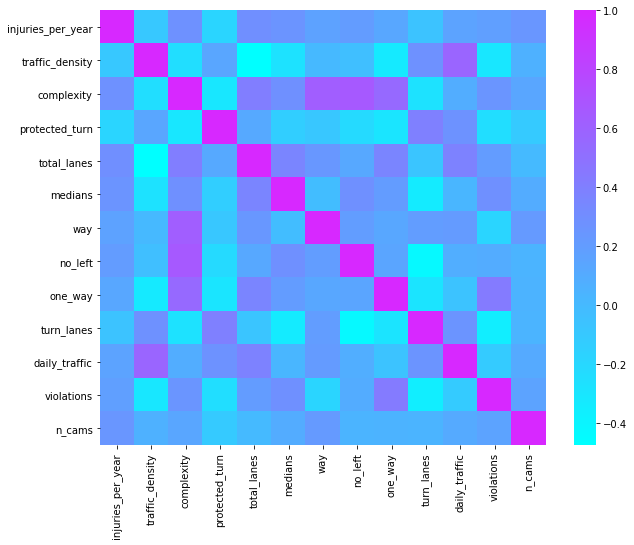

In [523]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [524]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'traffic_density', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'violations',
       'days_active', 'n_cams', 'start', 'end', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating'],
      dtype='object')

In [526]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = crash_df[categoricals] # defined earlier

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [527]:
pd.options.display.max_columns = 100
df_final.head()

,injuries_per_year,traffic_density,complexity,protected_turn,total_lanes,medians,way,no_left,one_way,turn_lanes,daily_traffic,violations,n_cams,exit,split,underpass,angled,triangle,rlc
0,6.396495,7183,1,2,6,2,4,0,0,2,43100,21792,2,0,0,0,1,0,1
1,0.000000,7083,0,4,6,2,4,0,0,4,42500,10290,2,0,0,0,0,0,1
2,4.397590,6966,0,4,6,2,4,0,0,4,41800,20257,2,0,0,0,0,0,1
3,3.797919,4610,3,2,10,2,4,2,0,0,46100,25816,2,0,1,0,0,0,1
4,3.797919,8075,1,2,8,2,4,0,0,2,64600,10891,2,0,1,0,0,0,1


## Feature selection

In [529]:
X = df_final.drop(target, axis=1)  # drop my potential targets
target = 'injuries_per_year'

y = df_final[target]

In [530]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg)
selector = selector.fit(X, y)


In [531]:
selector.support_ 
print('Feature Selection')
selected_features = []
print('{:>20} {:^8} {:^8} {:^8}'.format('FEATURE', 'RANK', 'SELECT', 'COEFFICIENT'))


#print(selector.estimator_.coef_)
step = 0

for i in range(len(X.columns)):
    rank = selector.ranking_[i]
    select = selector.support_[i]
    col = X.columns[i]
   
    if select: 
        coef = selector.estimator_.coef_[step]
        step+=1
        selected_features.append(col)
    else:
        coef = 0
    
    print('{:>20} {:^8} {:^10} {:^5.2f}'.format(col, rank, bool(select), coef))
        
intercept = selector.estimator_.intercept_
print('\nIntercept:', intercept)


Feature Selection
             FEATURE   RANK    SELECT  COEFFICIENT
     traffic_density    9         0      0.00 
          complexity    1         1      0.61 
      protected_turn    1         1      -0.26
         total_lanes    2         0      0.00 
             medians    5         0      0.00 
                 way    1         1      -0.70
             no_left    6         0      0.00 
             one_way    1         1      -0.59
          turn_lanes    1         1      0.63 
       daily_traffic    8         0      0.00 
          violations    7         0      0.00 
              n_cams    1         1      1.14 
                exit    4         0      0.00 
               split    1         1      3.50 
           underpass    1         1      1.75 
              angled    3         0      0.00 
            triangle    1         1      -1.43
                 rlc    10        0      0.00 

Intercept: 1.688967333234948


In [532]:
selector.ranking_

array([ 9,  1,  1,  2,  5,  1,  6,  1,  1,  8,  7,  1,  4,  1,  1,  3,  1,
       10])

In [533]:
estimators = selector.estimator_
print()
print(estimators.coef_)
print()
print(estimators.intercept_)


[ 0.60880161 -0.26067303 -0.69973148 -0.59162112  0.62918293  1.14033852
  3.49670144  1.75081227 -1.42667796]

1.688967333234948


## Apply my feature selection to data

In [534]:
X = X.iloc[:,selector.support_]

In [535]:
X.columns

Index(['complexity', 'protected_turn', 'way', 'one_way', 'turn_lanes',
       'n_cams', 'split', 'underpass', 'triangle'],
      dtype='object')

# Linear Regression

In [536]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [537]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [538]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      injuries_per_year   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     6.250
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           1.84e-07
Time:                        12:46:39   Log-Likelihood:                -357.83
No. Observations:                 158   AIC:                             735.7
Df Residuals:                     148   BIC:                             766.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6890      2.691      0.628      0.531      -3.630       7.008
complexity         0.6088      0.291      2.094      0.038       0.034       1.183
protected_turn    -0.2607      0.137     -1.905      0.059      -0.531       0.010
way               -0.6997      0.660     -1.061      0.291      -2.003       0.604
one_way           -0.5916      0.521     -1.136      0.258      -1.620       0.437
turn_lanes         0.6292      0.212      2.964      0.004       0.210       1.049
n_cams             1.1403      0.823      1.385      0.168      -0.487       2.768
split              3.4967      0.982      3.561      0.000       1.556       5.437
underpass          1.7508      0.519      3.374      0.001       0.725       2.776
triangle          -1.4267      0.785     -1.817      0.071      -2.979       0.125
==============================================================================
Omnibus:                       31.239   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.323
Skew:                           0.894   Prob(JB):                     2.93e-14
Kurtosis:                       5.504   Cond. No.                         92.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [545]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


reg = LinearRegression().fit(X, y)  # my regression object


# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
reg.fit(X, y)
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print()
print('Baseline r_squared val:', baseline)

  complexity: 0.6088016077324127
protected_turn: -0.26067302555858957
         way: -0.6997314773964943
     one_way: -0.5916211192128453
  turn_lanes: 0.6291829301278916
      n_cams: 1.1403385226920142
       split: 3.4967014355638457
   underpass: 1.7508122666175985
    triangle: -1.426677960834777

Baseline r_squared val: -0.3063807113856055


I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

In [332]:
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 22 columns):
injuries_per_year    158 non-null float64
crash_per_year       158 non-null float64
traffic_density      158 non-null int64
complexity           158 non-null int64
protected_turn       158 non-null int64
total_lanes          158 non-null int64
medians              158 non-null int64
way                  158 non-null int64
underpass            158 non-null int64
no_left              158 non-null int64
one_way              158 non-null int64
turn_lanes           158 non-null int64
daily_traffic        158 non-null int64
violations           158 non-null int64
n_cams               158 non-null int64
n_crash              158 non-null int64
injuries_total       158 non-null int64
exit                 158 non-null int64
split                158 non-null int64
angled               158 non-null int64
rlc                  158 non-null int64
triangle             158 non-null int64
dtypes: flo

In [267]:

from sklearn.ensemble import RandomForestClassifier


X = df_final.drop(columns=[target]).values
y = df_final[target].values

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)


In [263]:
forest.fit(X, y)

ValueError: Unknown label type: 'continuous'

In [266]:
from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=1, random_state=1)

# find all relevant features
feat_selector.fit(X, y)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

ValueError: Please check your X and y variable. The providedestimator cannot be fitted to your data.
Unknown label type: 'continuous'

In [244]:

# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(df_final.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

AttributeError: 'BorutaPy' object has no attribute 'ranking_'

In [ ]:
crash_df.head(20)

In [ ]:
# camera




int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)